In [1]:
import os
import cv2
import matplotlib.pyplot as plt

banana_dataset_path = 'D:/Mini_Project/Datasets/Banana/'
tomato_dataset_path = 'D:/Mini_Project/Datasets/Tomato/'

def load_images_from_subfolders(folder):
    images = []
    for root, _, files in os.walk(folder):
        for file in files:
            if file.endswith('.jpg'):
                img = cv2.imread(os.path.join(root, file))
                if img is not None:
                    # Convert BGR to RGB
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    images.append(img)
    return images

banana_images = load_images_from_subfolders(banana_dataset_path)
tomato_images = load_images_from_subfolders(tomato_dataset_path)

print("Number of Banana Images:", len(banana_images))
print("Number of Tomato Images:", len(tomato_images))

Number of Banana Images: 273
Number of Tomato Images: 2400


Sample Banana Images:


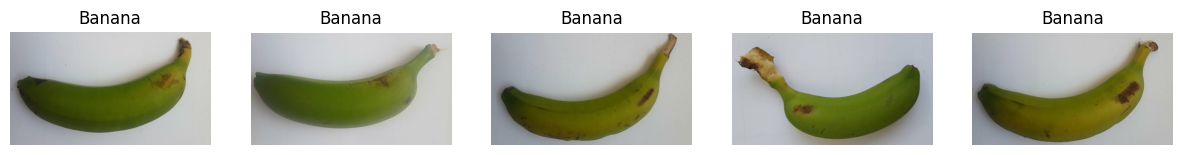

Sample Tomato Images:


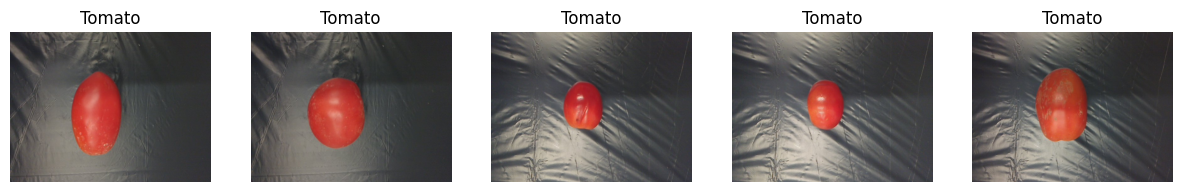

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def display_sample_images(images, labels, num_samples=5):
    num_images = min(num_samples, len(images))
    if num_images == 0:
        print("No images to display.")
        return
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i])
        ax.set_title(labels[i])
        ax.axis('off')
    plt.show()

print("Sample Banana Images:")
display_sample_images(banana_images, ['Banana'] * len(banana_images))

print("Sample Tomato Images:")
display_sample_images(tomato_images, ['Tomato'] * len(tomato_images))


In [3]:

target_size = (224, 224) 

def resize_images(images, target_size):
    resized_images = []
    for img in images:
        resized_img = cv2.resize(img, target_size)
        resized_images.append(resized_img)
    return resized_images

resized_banana_images = resize_images(banana_images, target_size)

resized_tomato_images = resize_images(tomato_images, target_size)


In [4]:
import numpy as np

banana_labels = np.full(len(resized_banana_images), 'Banana')
tomato_labels = np.full(len(resized_tomato_images), 'Tomato')

labels = np.concatenate([banana_labels, tomato_labels])

label_dict = {'Banana': 0, 'Tomato': 1}
encoded_labels = np.array([label_dict[label] for label in labels])

num_classes = len(label_dict)
categorical_labels = np.eye(num_classes)[encoded_labels]


In [5]:
import os
import cv2
import numpy as np

def load_images_from_subfolders(folder):
    images = []
    for root, _, files in os.walk(folder):
        for file in files:
            if file.endswith('.jpg'):
                img = cv2.imread(os.path.join(root, file))
                if img is not None:
                    images.append(img)
    return images

banana_images = load_images_from_subfolders('D:\Mini_Project\Datasets\Banana')
tomato_images = load_images_from_subfolders('D:\Mini_Project\Datasets\Tomato')

def resize_images(images, target_size):
    resized_images = []
    for img in images:
        resized_img = cv2.resize(img, target_size)
        resized_images.append(resized_img)
    return resized_images

target_size = (224, 224)

resized_banana_images = resize_images(banana_images, target_size)
resized_tomato_images = resize_images(tomato_images, target_size)

X = np.concatenate([resized_banana_images, resized_tomato_images])
y = np.concatenate([np.zeros(len(resized_banana_images)), np.ones(len(resized_tomato_images))])  # 0 for Banana, 1 for Tomato

split_ratio = 0.8
split_index_banana = int(len(resized_banana_images) * split_ratio)
split_index_tomato = int(len(resized_tomato_images) * split_ratio)

X_train = np.concatenate([resized_banana_images[:split_index_banana], resized_tomato_images[:split_index_tomato]])
y_train = np.concatenate([np.zeros(split_index_banana), np.ones(split_index_tomato)])

X_test = np.concatenate([resized_banana_images[split_index_banana:], resized_tomato_images[split_index_tomato:]])
y_test = np.concatenate([np.zeros(len(resized_banana_images) - split_index_banana), np.ones(len(resized_tomato_images) - split_index_tomato)])

train_folder = 'D:\Mini_Project\Datasets\Classification\Train'
test_folder = 'D:\Mini_Project\Datasets\Classification\Test'

os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

def save_images_to_folder(images, labels, folder):
    for i, (image, label) in enumerate(zip(images, labels)):
        class_folder = os.path.join(folder, str(int(label)))
        os.makedirs(class_folder, exist_ok=True)
        image_path = os.path.join(class_folder, f'image_{i}.jpg')
        cv2.imwrite(image_path, image)

save_images_to_folder(X_train, y_train, train_folder)
save_images_to_folder(X_test, y_test, test_folder)



In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import scipy.ndimage


train_folder = 'D:/Mini_Project/Datasets/Classification/Train'
test_folder = 'D:/Mini_Project/Datasets/Classification/Test'

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'  
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary' 
)

base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size
)

loss, accuracy = model.evaluate(test_generator)
print("Test Accuracy:", accuracy)


Found 2138 images belonging to 2 classes.
Found 535 images belonging to 2 classes.
Epoch 1/10


C:\Users\Praharsha Sri\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.9875 - loss: 0.0737 - val_accuracy: 1.0000 - val_loss: 8.7749e-05
Epoch 2/10
 1/66 ━━━━━━━━━━━━━━━━━━━━ 50s 772ms/step - accuracy: 1.0000 - loss: 1.2185e-06

C:\Users\Praharsha Sri\AppData\Local\Programs\Python\Python39\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 1.0000 - loss: 1.2185e-06 - val_accuracy: 1.0000 - val_loss: 1.2728e-08
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 1.0000 - loss: 1.0879e-04 - val_accuracy: 1.0000 - val_loss: 4.5061e-08
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 2.1478e-10 - val_accuracy: 1.0000 - val_loss: 3.8782e-10
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 1.0000 - loss: 3.4400e-06 - val_accuracy: 1.0000 - val_loss: 1.8518e-08
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 6.9115e-11 - val_accuracy: 1.0000 - val_loss: 1.6679e-10
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 1.0000 - loss: 9.2079e-07 - val_accuracy: 1.0000 - val_loss: 1.3119e-08
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 5.4812e-08 - val_accuracy: 1.0000 - val_loss: 1.7405e-11
Epoch 9/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 1.0000 - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


C:\Users\Praharsha Sri\AppData\Local\Temp\ipykernel_1832\3234253475.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_label = class_names[int(predicted_labels[i])]


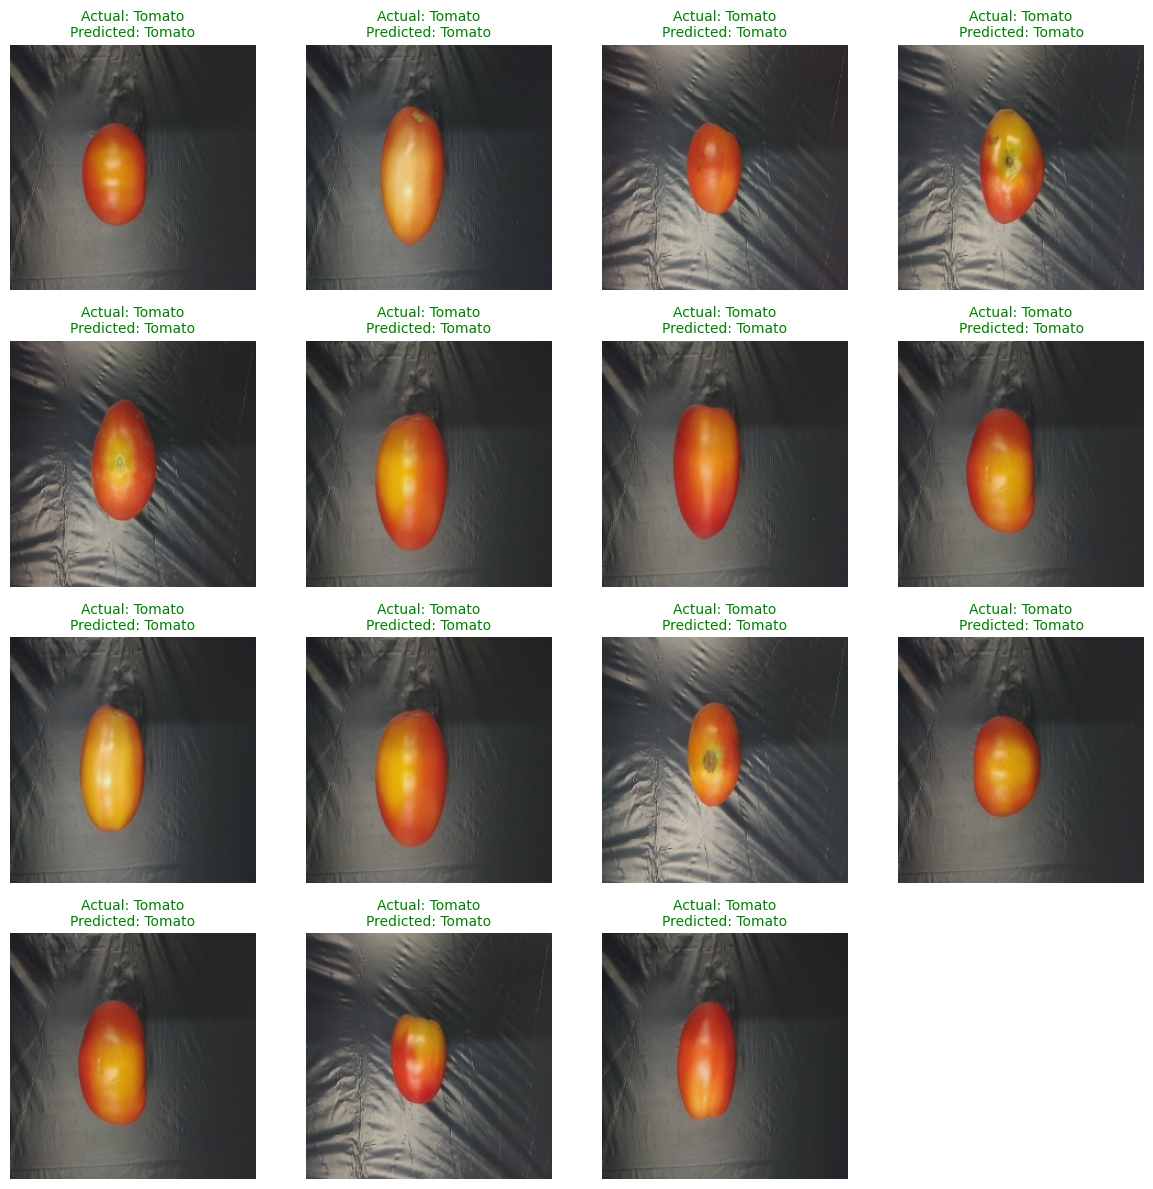

In [7]:
import numpy as np
import matplotlib.pyplot as plt

test_samples, test_labels = next(test_generator)
predictions = model.predict(test_samples)
predicted_labels = np.round(predictions).astype(int)
class_names = ['Banana', 'Tomato']

num_samples = min(len(test_samples), 15)
plt.figure(figsize=(12, 12))
for i in range(num_samples):
    plt.subplot(4, 4, i + 1)
    plt.imshow(test_samples[i])
    plt.axis('off')
    true_label = class_names[int(test_labels[i])]
    predicted_label = class_names[int(predicted_labels[i])]
    color = 'green' if true_label == predicted_label else 'red'
    plt.title(f'Actual: {true_label}\nPredicted: {predicted_label}', color=color, fontsize=10)
plt.tight_layout()
plt.show()


In [10]:
from keras.models import load_model

model_path = 'D:/Mini_Project/fruit_analyzer_app/models/fruit_classification_model.keras'
model.save(model_path)
